<a href="https://colab.research.google.com/github/tyoc213/fastai_xla_extensions/blob/explorations1/explore_nbs/Basic_lenet_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install fastai2 from github

In [1]:
!pip install git+https://github.com/fastai/fastcore
!pip install git+https://github.com/fastai/fastai2

  Cloning https://github.com/fastai/fastcore to /tmp/pip-req-build-2r8z38b1
  Running command git clone -q https://github.com/fastai/fastcore /tmp/pip-req-build-2r8z38b1
  Created wheel for fastcore: filename=fastcore-0.1.18-cp36-none-any.whl size=28891 sha256=f319739a3a0079dfb6279dfc7669c0621892c50801f6334c7d9637385834b470
  Stored in directory: /tmp/pip-ephem-wheel-cache-firtdulz/wheels/8a/2a/23/bc50c8f5e28776b44ac837a01fcfa675724565d4813d8e51c7
Successfully built fastcore
  Cloning https://github.com/fastai/fastai2 to /tmp/pip-req-build-yzit7jjo
  Running command git clone -q https://github.com/fastai/fastai2 /tmp/pip-req-build-yzit7jjo
  Created wheel for fastai2: filename=fastai2-0.0.18-cp36-none-any.whl size=193924 sha256=c3f0f530cad820a1b8af4b3e1d7d7eaba52b8bc76df4a5eac24373e770477dc0
  Stored in directory: /tmp/pip-ephem-wheel-cache-dwituj1v/wheels/a1/59/9a/50335b36924b827e29d5f40b41fc3a008cc1f30dd80e560dfd
Successfully built fastai2


In [2]:
from fastai2.vision.all import *

[('__call__', <function LevelMapper.__call__ at 0x7f33eaa587b8>), ('__init__', <function LevelMapper.__init__ at 0x7f33eaa58730>)]
[('__call__', <function BalancedPositiveNegativeSampler.__call__ at 0x7f33ea920378>), ('__init__', <function BalancedPositiveNegativeSampler.__init__ at 0x7f33ea9202f0>)]
[('__init__', <function BoxCoder.__init__ at 0x7f33ea920400>), ('decode', <function BoxCoder.decode at 0x7f33ea929510>), ('decode_single', <function BoxCoder.decode_single at 0x7f33ea9296a8>), ('encode', <function BoxCoder.encode at 0x7f33ea929598>), ('encode_single', <function BoxCoder.encode_single at 0x7f33ea929620>)]
[('__call__', <function Matcher.__call__ at 0x7f33ea9297b8>), ('__init__', <function Matcher.__init__ at 0x7f33ea920268>), ('set_low_quality_matches_', <function Matcher.set_low_quality_matches_ at 0x7f33ea929950>)]
[('__init__', <function ImageList.__init__ at 0x7f33ea929a60>), ('to', <function ImageList.to at 0x7f33ea929b70>)]
[('__init__', <function Timebase.__init__ at

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)
path.ls()[2].ls()

(#2) [Path('/root/.fastai/data/mnist_sample/valid/7'),Path('/root/.fastai/data/mnist_sample/valid/3')]

In [4]:
def get_my_labels(fname):
    return int(fname.parent.name[0])

dblock = DataBlock(
    splitter = RandomSplitter(),
    #item_tfms = Resize(128),
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    get_y = get_my_labels
)


In [5]:
dls_normal = dblock.dataloaders(path)
dls_normal.vocab

(#2) [3,7]

# Lenet with convs and F.max_pool2d

In [6]:
class MyLenet(nn.Module):
    def __init__(self):
        super(MyLenet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6,16,3)
        self.hiden4 = nn.Linear(400, 2) # 2 outputs instead of 10
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = self.hiden4(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

lenet = MyLenet()
learn = Learner(dls_normal, lenet, metrics=[error_rate, accuracy])

learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.096199,0.066584,0.022523,0.977477,00:13


In [7]:
learn.validate()

(#3) [0.06658371537923813,0.022522522136569023,0.977477490901947]

# Lenet with layers

In [14]:
class Lenet2(nn.Module):
    def __init__(self):
        super(Lenet2, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2) # Only 2 outputs instead of 10
    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features



lenet2 = Lenet2()
learn2 = Learner(dls_normal, lenet2, metrics=[error_rate, accuracy])

learn2.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.069667,0.044307,0.014207,0.985793,00:14


In [9]:
learn.validate()

(#3) [0.06658371537923813,0.022522522136569023,0.977477490901947]

# conectarse a TPU

In [10]:
VERSION = "20200325"  #"20200515" @param ["1.5" , "20200325", "nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4994  100  4994    0     0  78031      0 --:--:-- --:--:-- --:--:-- 78031


In [11]:
!TORCH_SHOW_CPP_STACKTRACES=1 python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev

Updating... This may take around 2 minutes.
Updating TPU runtime to pytorch-dev20200515 ...
Uninstalling torch-1.6.0a0+bf2bbd9:
  Successfully uninstalled torch-1.6.0a0+bf2bbd9
Uninstalling torchvision-0.7.0a0+a6073f0:
  Successfully uninstalled torchvision-0.7.0a0+a6073f0
Copying gs://tpu-pytorch/wheels/torch-nightly+20200515-cp36-cp36m-linux_x86_64.whl...
- [1 files][ 91.0 MiB/ 91.0 MiB]                                                
Operation completed over 1 objects/91.0 MiB.                                     
Copying gs://tpu-pytorch/wheels/torch_xla-nightly+20200515-cp36-cp36m-linux_x86_64.whl...
- [1 files][119.5 MiB/119.5 MiB]                                                
Operation completed over 1 objects/119.5 MiB.                                    
Copying gs://tpu-pytorch/wheels/torchvision-nightly+20200515-cp36-cp36m-linux_x86_64.whl...
/ [1 files][  2.3 MiB/  2.3 MiB]                                                
Operation completed over 1 objects/2.3 MiB.        

In [12]:
import torch_xla.core.xla_model as xm

class XLAOptFuncWrapper:
    def __init__(self, f):
        self.f = f
    def __call__(self, *args, **kwargs):
        opt = self.f(*args, **kwargs)
        optim_wrapper = OptimWrapper(opt)
        def xla_step():
            xm.optimizer_step(opt, barrier=True)
        # monkeypatch optim_wrapper with xla_step
        optim_wrapper.step = xla_step
        return optim_wrapper

# Load in TPU

In [13]:
dblock.summary(path)

Setting-up type transforms pipelines
Found 14434 items
2 datasets of sizes 11548,2886
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_my_labels -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/mnist_sample/valid/7/8891.png
    applying PILBase.create gives
      PILImage mode=RGB size=28x28
  Pipeline: get_my_labels -> Categorize
    starting from
      /root/.fastai/data/mnist_sample/valid/7/8891.png
    applying get_my_labels gives
      7
    applying Categorize gives
      TensorCategory(1)

Final sample: (PILImage mode=RGB size=28x28, TensorCategory(1))


Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor

Building one batch
Applying item_tfms to the first sample:
  Pipeline: ToTensor
    starting from
      (PILImage mode=RGB size=28x28, TensorCategory(1))
    applying ToTensor gives
      (TensorImage of size 3x28x28, TensorCategory(1

# Use TPU device

(None, (#2) [3,7])

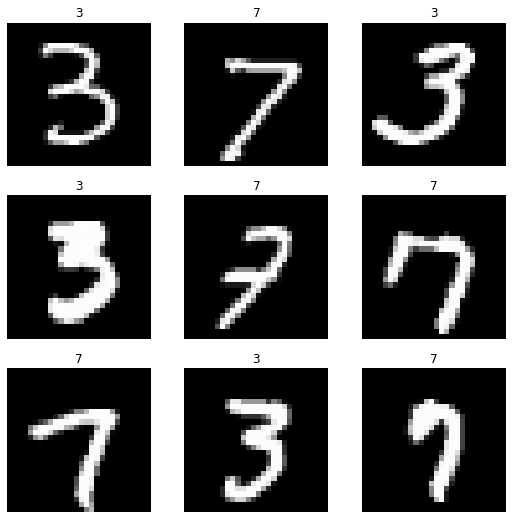

In [15]:
tpu_device = xm.xla_device()
dls_tpu = dblock.dataloaders(path, device=tpu_device)
dls_tpu.show_batch(), dls_tpu.vocab

In [16]:
dls_tpu.show([1])

In [18]:
sgd_xla_opt = XLAOptFuncWrapper(SGD)
adam_xla_opt = XLAOptFuncWrapper(Adam)


In [19]:
# from fastai2.callback.all import *
from fastai2.test_utils import *
lenet_tpu = Lenet2()
tpu_learner = Learner(dls_tpu, lenet_tpu, metrics=accuracy, 
                      loss_func=F.cross_entropy, opt_func=adam_xla_opt, cbs=VerboseCallback())

In [20]:
tpu_learner.summary()

Lenet2 (Input shape: ['64 x 3 x 28 x 28'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 6 x 26 x 26     168        True      
________________________________________________________________
Conv2d               64 x 16 x 11 x 11    880        True      
________________________________________________________________
Linear               64 x 120             48,120     True      
________________________________________________________________
Linear               64 x 84              10,164     True      
________________________________________________________________
Linear               64 x 2               170        True      
________________________________________________________________

Total params: 59,502
Total trainable params: 59,502
Total non-trainable params: 0

Optimizer used: <__main__.XLAOptFuncWrapper object at 0x7f33d7202b00>
Loss function: <function cross_entropy at 0x7f33f9953950>

Callbacks:
  - TrainEvalCallback
  

In [21]:
tpu_learner.show_training_loop()

Start Fit
   - begin_fit      : [TrainEvalCallback, Recorder, ProgressCallback]
  Start Epoch Loop
     - begin_epoch    : [Recorder, ProgressCallback]
    Start Train
       - begin_train    : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - begin_batch    : []
         - after_pred     : []
         - after_loss     : []
         - after_backward : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - begin_validate : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - after_validate : [Recorder, ProgressCallback]
  End Epoch Loop
   - after_cancel_epoch: []
   - after_epo

# Call fit

Will fail in `self.loss.backward(); `?

In [23]:
tpu_learner.fit(1)

begin_fit


begin_epoch
begin_train
begin_batch
after_pred
after_loss
after_batch
after_train
after_epoch
after_fit


RuntimeError: ignored

In [24]:
tpu_learner.lr_find()

begin_fit


begin_epoch
begin_train
begin_batch
after_pred
after_loss
after_batch
after_train
after_epoch
after_fit


RuntimeError: ignored

reference for https://pytorch.org/docs/stable/autograd.html#torch.autograd.backward

In [25]:
ob = tpu_learner.dls.train.one_batch()
#print(ob)
len(ob), ob[0].shape, ob[1].shape, F.cross_entropy, tpu_learner.pred

(2,
 torch.Size([64, 3, 28, 28]),
 torch.Size([64]),
 <function torch.nn.functional.cross_entropy>,
 None)

# patch one_batch with the code and some extra prints

In [27]:
import traceback

@patch_to(Learner)
def one_batch(self, i, b):
        print(f"******************** self is {self} i is {i}")
        self.iter = i
        try:
            self._split(b);                                  self('begin_batch')
            self.pred = self.model(*self.xb);                self('after_pred')
            if len(self.yb) == 0: return
            self.loss = self.loss_func(self.pred, *self.yb); self('after_loss')
            print(f"******************** self.loss is {self.loss}")
            print(f"******************** self.loss.device = {self.loss.device}")
            if not self.training: return
            print(f"******************** will calculate gradient for loss {type(self.loss)} {self.loss.shape}")
            try:
              self.loss.backward()
            except Exception as e:
              print(f"******************** did fail")
              print(f"{e}")
              tb = sys.exc_info()[2]
              #etype, value, tb = e
              traceback.print_tb(tb) #print_exception(e)

            self.loss.backward();                            self('after_backward')
            print(f"******************** PASSED")
            self.opt.step();                                 self('after_step')
            self.opt.zero_grad()
        except CancelBatchException:                         self('after_cancel_batch')
        finally:                                             self('after_batch')

#my_one_batch(tpu_learner, 0, 64)
print(tpu_learner.splitter)
print(tpu_learner._split)

tpu_learner.fit(1)

<function trainable_params at 0x7f33f88e6f28>
<bound method Learner._split of <fastai2.learner.Learner object at 0x7f33d6f80ac8>>
begin_fit


begin_epoch
begin_train
******************** self is <fastai2.learner.Learner object at 0x7f33d6f80ac8> i is 0
begin_batch
after_pred
after_loss
******************** self.loss is 0.693072497844696
******************** self.loss.device = xla:1
******************** will calculate gradient for loss <class 'torch.Tensor'> torch.Size([])
******************** did fail
vector::_M_range_check: __n (which is 1) >= this->size() (which is 1)


  File "<ipython-input-27-4b36e6c15e89>", line 17, in one_batch
    self.loss.backward()
  File "/usr/local/lib/python3.6/dist-packages/torch/tensor.py", line 184, in backward
    torch.autograd.backward(self, gradient, retain_graph, create_graph)
  File "/usr/local/lib/python3.6/dist-packages/torch/autograd/__init__.py", line 123, in backward
    allow_unreachable=True)  # allow_unreachable flag


after_batch
after_train
after_epoch
after_fit


RuntimeError: ignored

In [ ]:
#the_loss = tpu_learner.loss_func(tpu_learner.pred, *tpu_learner.yb)
the_loss = tpu_learner.loss_func(tpu_learner.dls, *tpu_learner.yb)

AttributeError: ignored